# Import Required Libraries

In [1]:
# Importing the required packages and libraries 
import pickle
import numpy as np
import cv2
import glob2
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

# Camera Calibration

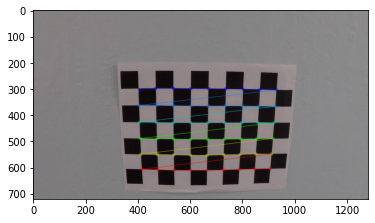

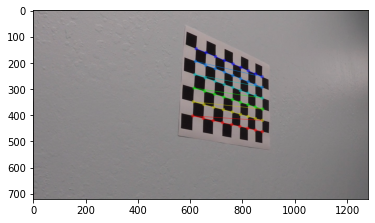

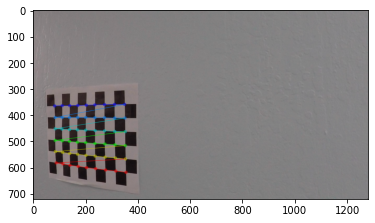

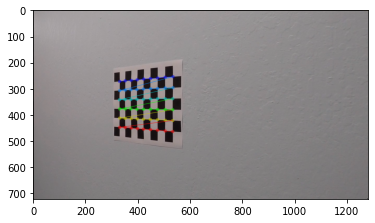

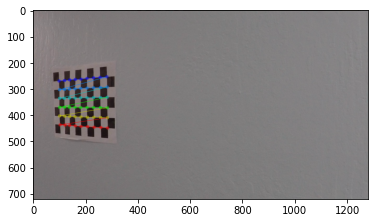

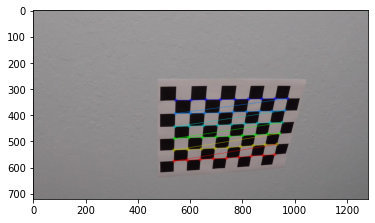

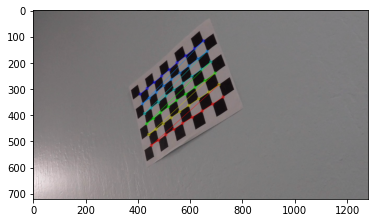

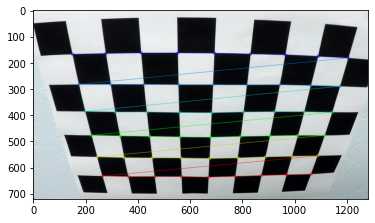

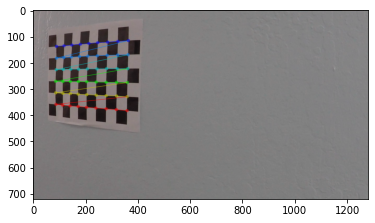

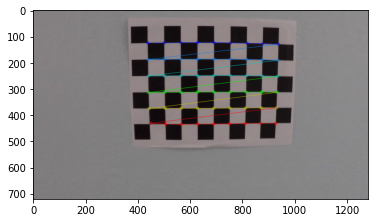

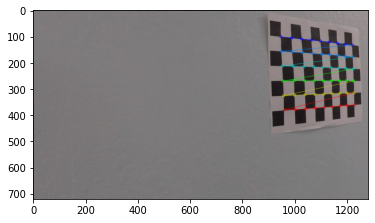

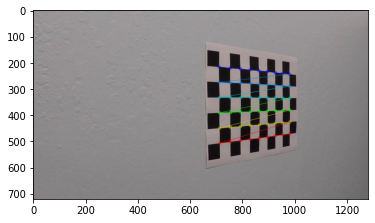

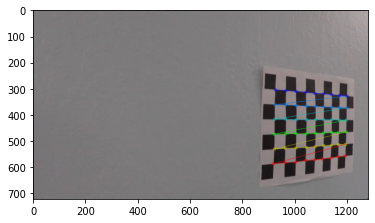

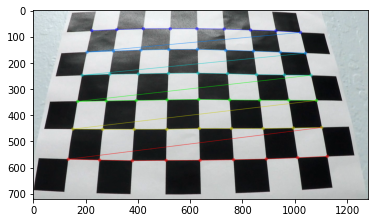

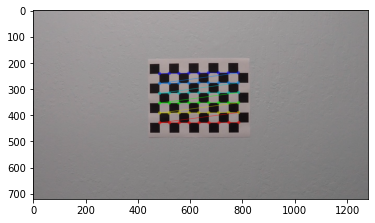

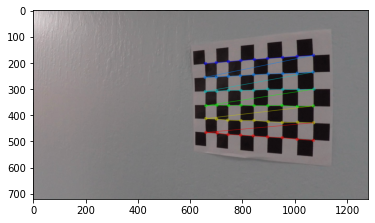

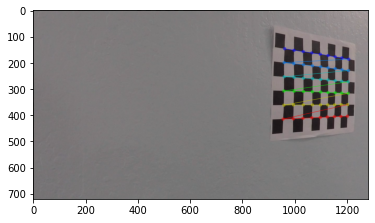

In [2]:
# Make a list of calibration images
images = glob2.glob('/home/d9adshot/Downloads/CarND-Advanced-Lane-Lines-master/camera_cal/calibration*.jpg')

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
nx = 9
ny = 6

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname) # Reading in the image
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # Converting BGR to GRAY

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img, cmap='gray')
        plt.show()
        
image_size = (img.shape[1], img.shape[0]) # Saving the size of the image
global mtx
global dist

# Extracting the camera calibration matrix and distortion coefficients 
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_size, None, None)

# Distortion Correction on Chessboard

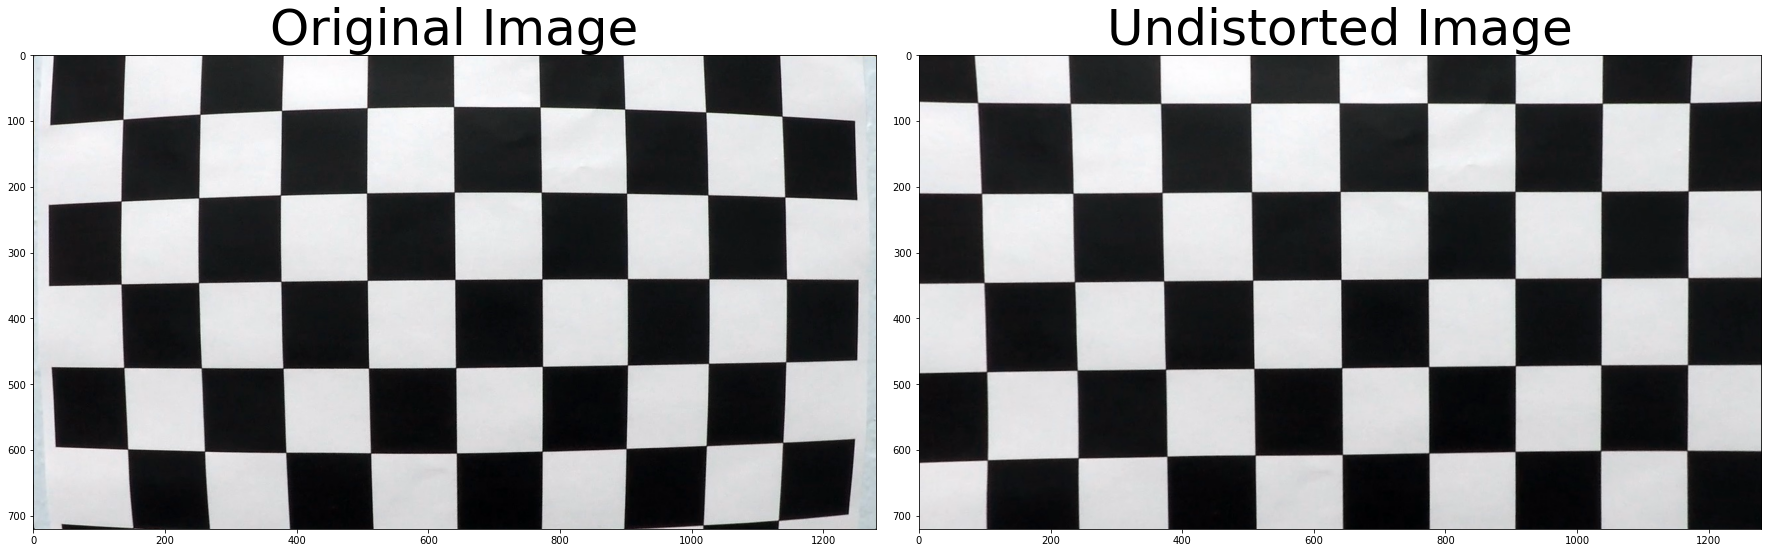

In [3]:
# Reading in an image
raw_image = cv2.imread('/home/d9adshot/Downloads/CarND-Advanced-Lane-Lines-master/camera_cal/calibration1.jpg')

undistorted = cv2.undistort(raw_image, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(raw_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Distortion Correction on Test Image

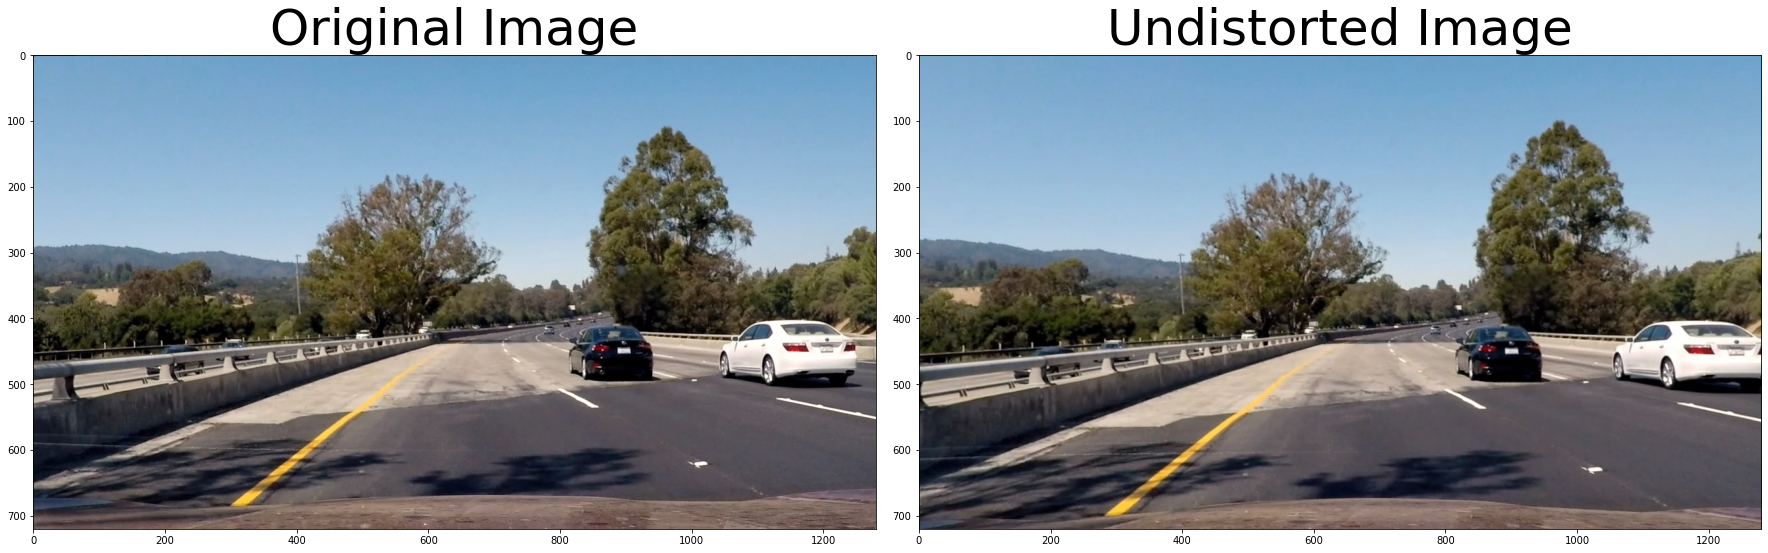

In [4]:
# testing our undistortion on some test image
raw_image2 = cv2.imread('/home/d9adshot/Downloads/CarND-Advanced-Lane-Lines-master/test_images/test4.jpg')
raw_image2 = cv2.cvtColor(raw_image2, cv2.COLOR_BGR2RGB)

undistorted2 = cv2.undistort(raw_image2, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(raw_image2)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted2)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Binary Threshold

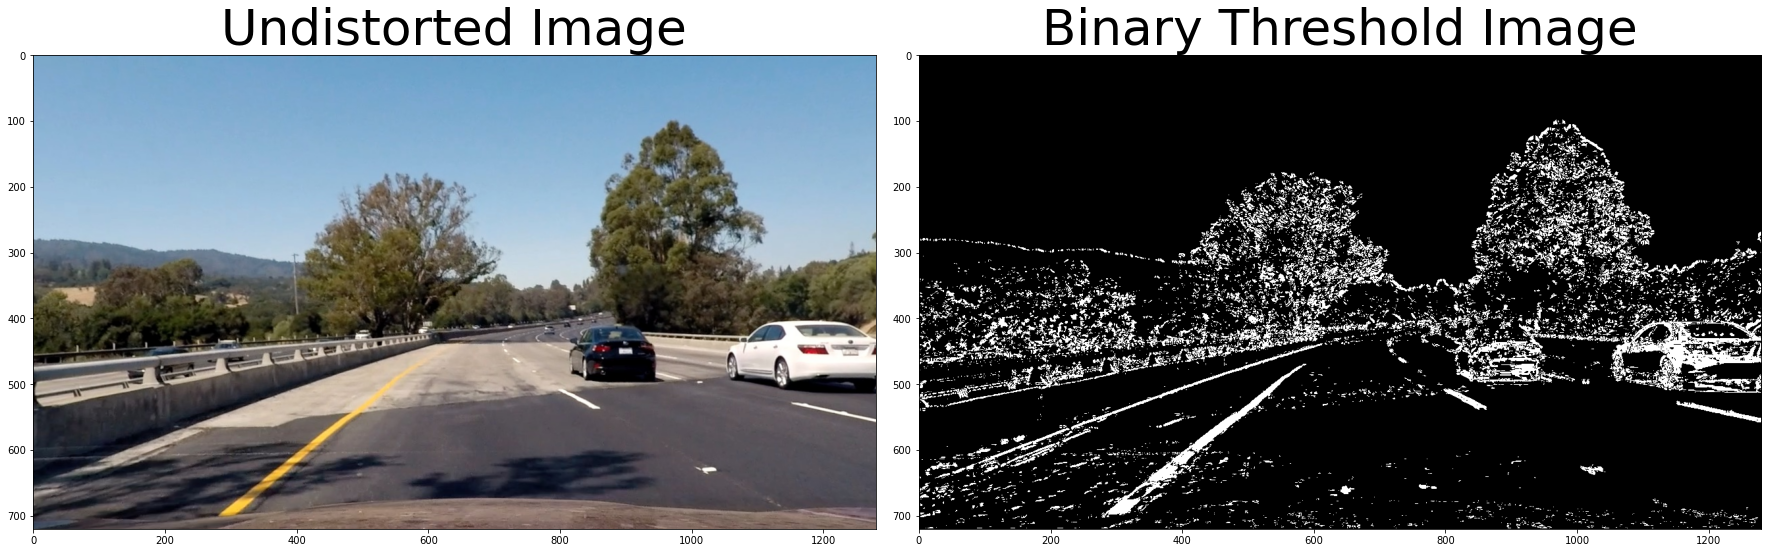

In [5]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def combine_binary(img, mag_binary, dir_binary, hls_binary, gradx_binary, grady_binary):
    """Combines gradients and color channel thresholding""" 
    
    binary_output = np.zeros_like(dir_binary)
    binary_output[((gradx_binary == 1) & (grady_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (hls_binary == 1)] = 1    

    return binary_output


gradx_binary = abs_sobel_thresh(undistorted2, 'x', 15, 255)
grady_binary = abs_sobel_thresh(undistorted2, 'y', 15, 255)
mag_binary = mag_thresh(undistorted2, 3, mag_thresh=(20, 255))
dir_binary = dir_thresh(undistorted2, 15, (0.7, 1.3))
hls_binary = hls_select(undistorted2, thresh=(170, 255))
binary_image = combine_binary(undistorted2, mag_binary, dir_binary, hls_binary, gradx_binary, grady_binary)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted2)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(binary_image, cmap='gray')
ax2.set_title('Binary Threshold Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Birds-eye View Transformation

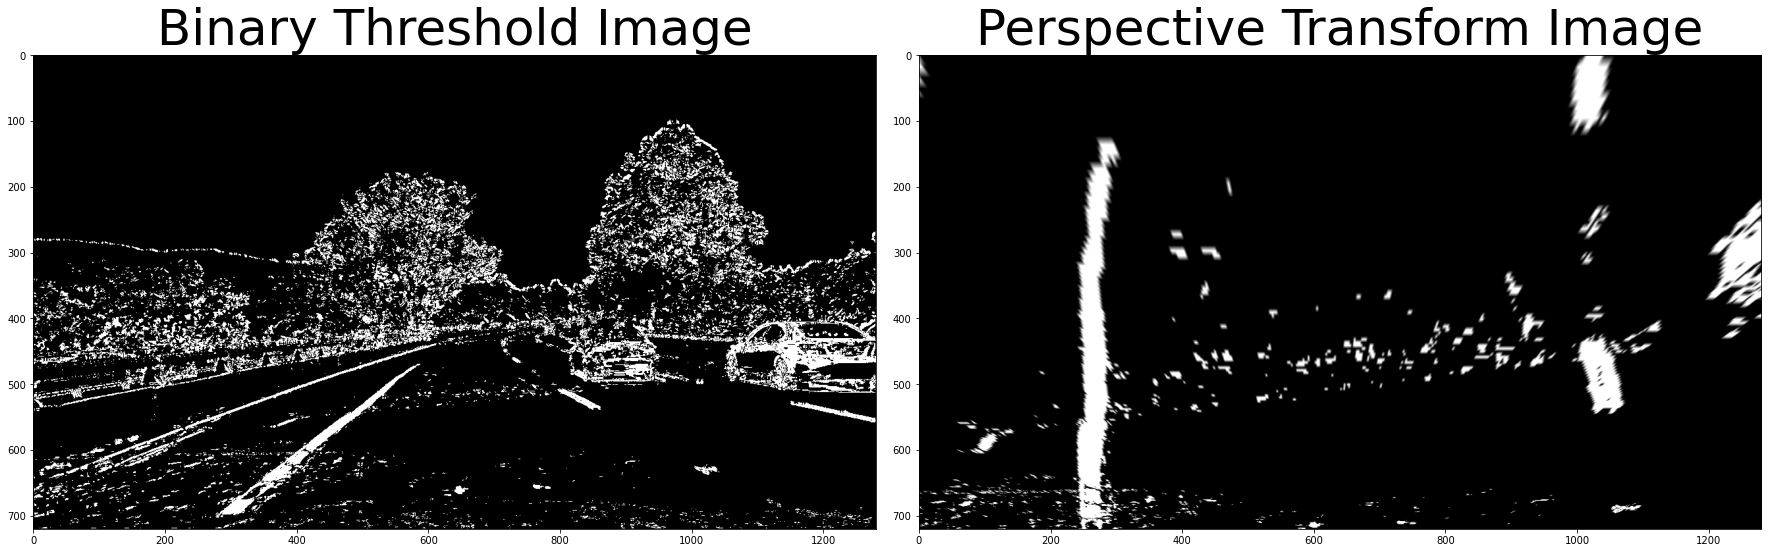

In [6]:
height, width = binary_image.shape[0:2]
global src 
src = np.float32(
        [
            [580.0, 460.0],
            [740.0, 460.0],      # Defining the source coordinates
            [1100.0, 670.0],
            [270.0, 670.0],
        ]
    )
    
global dst
dst = np.float32(
        [
            [200.0, 0],
            [width - 200.0, 0], # Defining the destination coordinates for the perspective image
            [width - 200.0, height],
            [200.0, height],
        ]
    )


def corners_unwarp(img, nx, ny, mtx, dist):
    # Pass in your image into this function
    img_size = (img.shape[1], img.shape[0])
    offset = 100
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # e) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size)
    return warped, M, Minv

global Minv
top_down, perspective_M, Minv = corners_unwarp(binary_image, 9, 6, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(binary_image, cmap='gray')
ax1.set_title('Binary Threshold Image', fontsize=50)
ax2.imshow(top_down, cmap='gray')
ax2.set_title('Perspective Transform Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Lane Detection

## Part 1 - Sliding Window

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


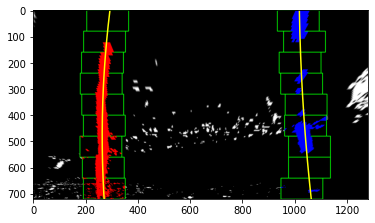

In [7]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, left_lane_inds, right_lane_inds, out_img

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, left_lane_inds, right_lane_inds, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_lane_inds, right_lane_inds, left_fit, right_fit


out_img, left_lane_inds1, right_lane_inds1, left_fit1, right_fit1 = fit_polynomial(top_down)

plt.imshow(out_img)

## Part 2 - Search From Prior

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


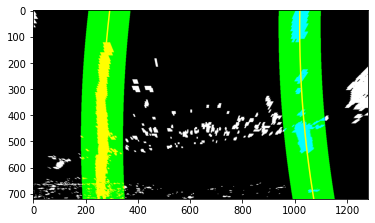

In [8]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each with np.polyfit()
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2) 
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    # Calc both polynomials using ploty, left_fit and right_fit
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 80

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx, lefty, rightx, righty,left_lane_inds1, right_lane_inds1, out_img = find_lane_pixels(binary_warped)
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty, left_fit2, right_fit2 = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result, left_lane_inds, right_lane_inds, left_fit2, right_fit2

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
global left_lane_inds, right_lane_inds, left_fit, right_fit
result, left_lane_inds, right_lane_inds, left_fit, right_fit = search_around_poly(top_down)

# View your output
plt.imshow(result)

# Radius of Curvature & Car Position Estimation

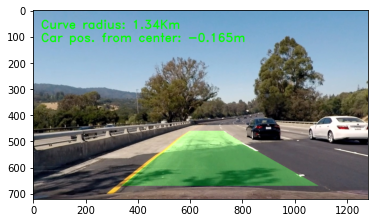

In [9]:
def measure_curvature(binary_warped, left_fit, right_fit, x_conv_factor=3.7/700, y_conv_factor = 30/720):
    """Calculates the curvature of polynomial functions in meters.""" 
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = y_conv_factor # meters per pixel in y dimension
    xm_per_pix = x_conv_factor # meters per pixel in x dimension
    
    # maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])    
    
    return left_curverad, right_curverad

def car_offset(binary_warped, left_fit, right_fit, xm_per_pix=3.7/700):
    """Calculates the vehicle position in the lane""" 
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    
    y_eval = np.max(ploty)
    #Calculate offset 
    car_position = binary_warped.shape[1]/2
    
    left_fitx = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_fitx = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    
    lane_center = (right_fitx + left_fitx) /2
    
    offset = (car_position - lane_center) * xm_per_pix
    
    return offset

def warp_lanes_onto_original(original_img, binary_img, left_fit, right_fit, Minv):
    ploty = np.linspace(0, binary_img.shape[0]-1, binary_img.shape[0])
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    #print(len(pts_left))
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    #print(len(pts_right))
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (original_img.shape[1], original_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(original_img, 1, newwarp, 0.3, 0)
    
    return result

def show_curvature_data(img, curv_rad, car_pos):
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:02.2f}'.format(curv_rad/1000) + 'Km'
    cv2.putText(img, text, (30,70), font, 1.5, (0,255,0), 2, cv2.LINE_AA)
    
    text = 'Car pos. from center: ' + '{:02.3f}'.format(car_pos) + 'm'
    cv2.putText(img, text, (30,120), font, 1.5, (0,255,0), 2, cv2.LINE_AA)
    
    return img


left_curverad, right_curverad = measure_curvature(top_down, left_fit, right_fit,x_conv_factor=3.7/700, y_conv_factor = 30/720)
offset = car_offset(top_down, left_fit, right_fit, xm_per_pix=3.7/700)
new_img = warp_lanes_onto_original(undistorted2, top_down, left_fit, right_fit, Minv)
final_img = show_curvature_data(new_img, (left_curverad + right_curverad)/2, offset)

plt.imshow(final_img)

# Video (Pipeline)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4



Moviepy - Done !
Moviepy - video ready project_video_output.mp4
CPU times: user 11min 5s, sys: 18 s, total: 11min 23s
Wall time: 5min 2s


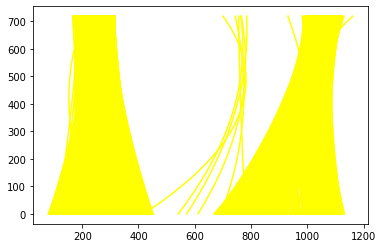

In [12]:
# We define a class to keep track of things like our last several detections of the lane lines and curvatures
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False      
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
    
    # Defining a function to detect the best fitting line in each video frame    
    def add_best_fit(self, lane_fit, lane_inds):
        if lane_fit is not None:
            if self.best_fit is not None:
                self.diffs = abs(lane_fit - self.best_fit)
            if (self.diffs[0] > 0.001 or self.diffs[1] > 1.0 or self.diffs[2] > 100.) and len(self.current_fit) > 0:
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(lane_inds)
                self.current_fit.append(lane_fit)
                if len(self.current_fit) > 5:
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = lane_fit
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
                self.best_fit = np.average(self.current_fit, axis=0)  
    
    def process_img(img):
        original_img = np.copy(img)
    
        undist = cv2.undistort(original_img, mtx, dist, None, mtx)
        
        gradx_binary = abs_sobel_thresh(undist, 'x', 20, 255)
        grady_binary = abs_sobel_thresh(undist, 'y', 20, 255)
        mag_binary = mag_thresh(undist, 3, mag_thresh=(40, 255))
        dir_binary = dir_thresh(undist, 15, (0.7, 1.3))
        hls_binary = hls_select(undist, thresh=(170, 255))
        binary_img = combine_binary(undist, mag_binary, dir_binary, hls_binary, gradx_binary, grady_binary)
        
        warped_image, M, Minv = corners_unwarp(binary_img, 9, 6, mtx, dist)
    
        if not left_line.detected or not right_line.detected:
            out_img, left_lane_inds, right_lane_inds, left_fit, right_fit = fit_polynomial(warped_image)
        else:
            out_img, left_lane_inds, right_lane_inds, left_fit, right_fit = search_around_poly(warped_image)
        left_line.add_best_fit(left_fit, left_lane_inds)
        right_line.add_best_fit(right_fit, right_lane_inds)
        
        if left_line.best_fit is not None and right_line.best_fit is not None:
            new_img = warp_lanes_onto_original(original_img, warped_image, left_line.best_fit, right_line.best_fit, Minv)
        
            left_curverad, right_curverad = measure_curvature(warped_image, left_line.best_fit, right_line.best_fit, x_conv_factor=3.7/700, y_conv_factor = 30/720)
            car_pos = car_offset(warped_image, left_line.best_fit, right_line.best_fit, xm_per_pix=3.7/700)
        
            final_img = show_curvature_data(new_img, (left_curverad + right_curverad)/2, car_pos)
        else:
            new_img = original_img
        return new_img

left_line = Line()
right_line = Line()

video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('/home/d9adshot/Downloads/CarND-Advanced-Lane-Lines-master/project_video.mp4')
processed_video = video_input1.fl_image(Line.process_img)
%time processed_video.write_videofile(video_output1, audio=False)